<a href="https://colab.research.google.com/github/aberdichevskaya/ML_BI/blob/hw_7_8/hw7_8/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [88]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [90]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [91]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** чем больше размер, тем быстрее

Посмотрим на какую-нибудь картинку:

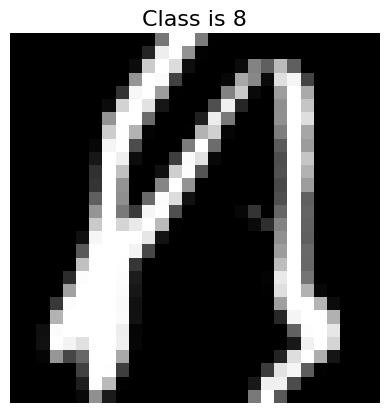

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [7]:
pics_to_show = []
cl = 0
for obj in trainset:
    if obj[1] == cl:
        pics_to_show.append(obj)
        cl += 1
    if cl > 10:
        break

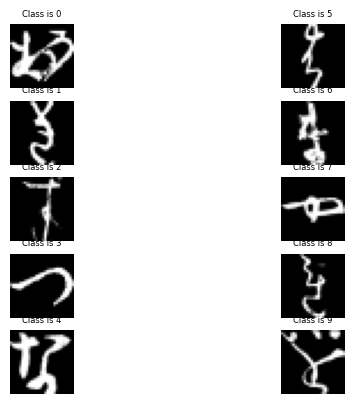

In [25]:
plt.rc('font', size=5)

fig, axs = plt.subplots(5, 2)

for i in range(5):
    axs[i, 0].imshow(pics_to_show[i][0].view(28, 28).numpy(), cmap="gray")
    axs[i, 0].title.set_text(f"Class is {pics_to_show[i][1]}")
    axs[i, 0].axis("off")
for i in range(5):
    axs[i, 1].imshow(pics_to_show[i+5][0].view(28, 28).numpy(), cmap="gray")
    axs[i, 1].title.set_text(f"Class is {pics_to_show[i+5][1]}")
    axs[i, 1].axis("off")

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [4]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = nn.ReLU()
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        input = x.view(-1, 28*28)
        input = self.fc1(input)
        input = self.activation(input)
        input = self.fc2(input)
        input = self.activation(input)
        logits = self.fc3(input)
        
        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [30]:
sum = 0
for param in FCNet().parameters():
    if len(list(param.shape)) == 2:
      sum += param.shape[0] * param.shape[1]
    else:
      sum += param.shape[0]
print(sum)

235146


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [92]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [6]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [7]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
  epoch_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    outputs = fc_net(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  loss_history.append(epoch_loss / len(trainloader))


In [8]:
get_accuracy(fc_net, testloader)

0.8702

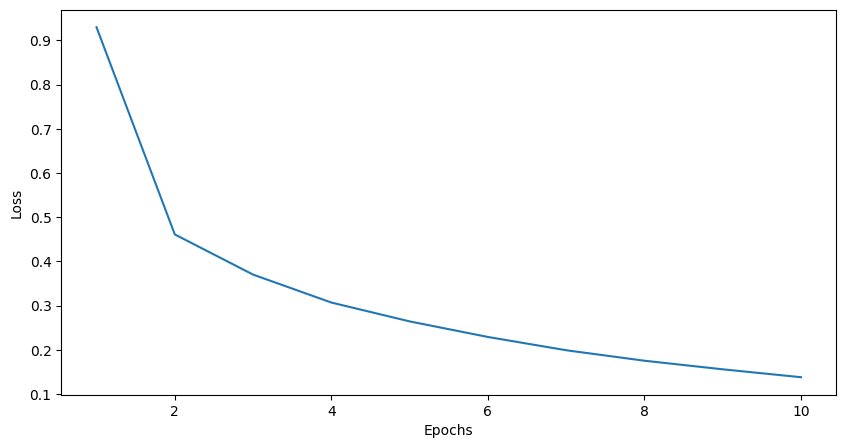

In [9]:
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(n_epochs)], loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [61]:
mean_array = []
for images, labels in  trainloader:   
    mean_array.append(images.mean(dim=(0,2,3))[0])

mean_array = np.array(mean_array)

In [62]:
mean = mean_array.mean()
mean

0.19174792

In [65]:
mean2 = np.array([np.power(trainset[i][0].numpy(), 2).mean() for i in range(len(trainset))]).mean()

In [67]:
D = mean2 - mean**2
std = D ** 0.5
std

0.34835065987042557

In [68]:
transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

In [69]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [70]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
  epoch_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    outputs = fc_net(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  loss_history.append(epoch_loss / len(trainloader))


In [71]:
get_accuracy(fc_net, testloader)

0.9028

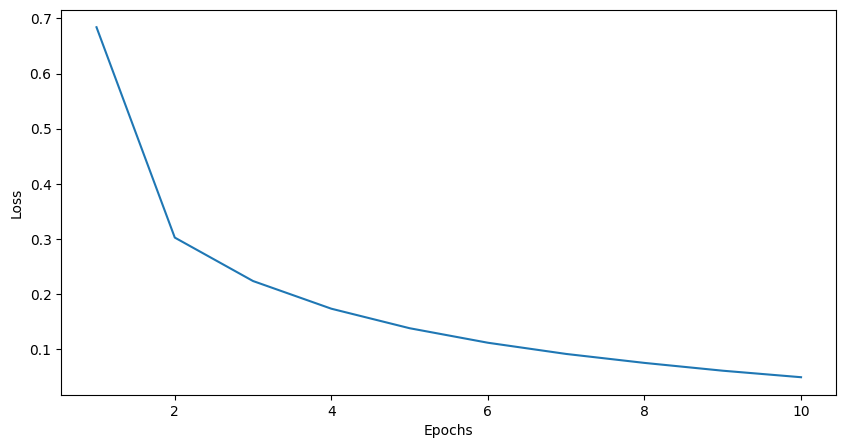

In [78]:
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(n_epochs)], loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Как изменилась `accuracy` после нормализации?

После нормализации accuracy заметно улучшилась

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [93]:
class FCNet_activation(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = activation
        

    def forward(self, x):
        input = x.view(-1, 28*28)
        input = self.fc1(input)
        input = self.activation(input)
        input = self.fc2(input)
        input = self.activation(input)
        logits = self.fc3(input)
        
        return logits

In [94]:
def train(model, optimizer, n_epoch=10):
  for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
      optimizer.zero_grad()
      outputs = model(images)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()

In [95]:
fcnet_sigmoid = FCNet_activation(nn.functional.sigmoid)
optimizer = torch.optim.Adam(fcnet_sigmoid.parameters(), lr=3e-4)
train(fcnet_sigmoid, optimizer)

In [96]:
get_accuracy(fcnet_sigmoid, testloader)

0.8087

In [97]:
fcnet_GELU = FCNet_activation(nn.functional.gelu)
optimizer = torch.optim.Adam(fcnet_GELU.parameters(), lr=3e-4)
train(fcnet_GELU, optimizer)

In [98]:
get_accuracy(fcnet_GELU, testloader)

0.8694

In [99]:
fcnet_tanh = FCNet_activation(nn.functional.tanh)
optimizer = torch.optim.Adam(fcnet_tanh.parameters(), lr=3e-4)
train(fcnet_tanh, optimizer)

In [100]:
get_accuracy(fcnet_tanh, testloader)

0.8817

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Лучше всего accuracy с использованием reLU

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [103]:
fc_net = FCNet()

In [104]:
optimizer = torch.optim.RMSprop(fc_net.parameters(), lr=3e-4)
train(fc_net, optimizer)

In [105]:
get_accuracy(fc_net, testloader)

0.8805

In [106]:
fc_net = FCNet()
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=3e-4)
train(fc_net, optimizer)

In [107]:
get_accuracy(fc_net, testloader)

0.6572

Оптимайзер Adam работает лучше всего

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [125]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.where(x >= 0, x, 0)

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [126]:
fcnet_custom_relu = FCNet_activation(CustomReLU())
optimizer = torch.optim.Adam(fcnet_custom_relu.parameters(), lr=3e-4)

In [127]:
train(fcnet_custom_relu, optimizer)

In [128]:
get_accuracy(fcnet_custom_relu, testloader)

0.877

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Изображение сгенерировано моделью ruDALL-E от Сбера по запросу "девочка аня пишет нейронку и излучает ненависть на весь мир"

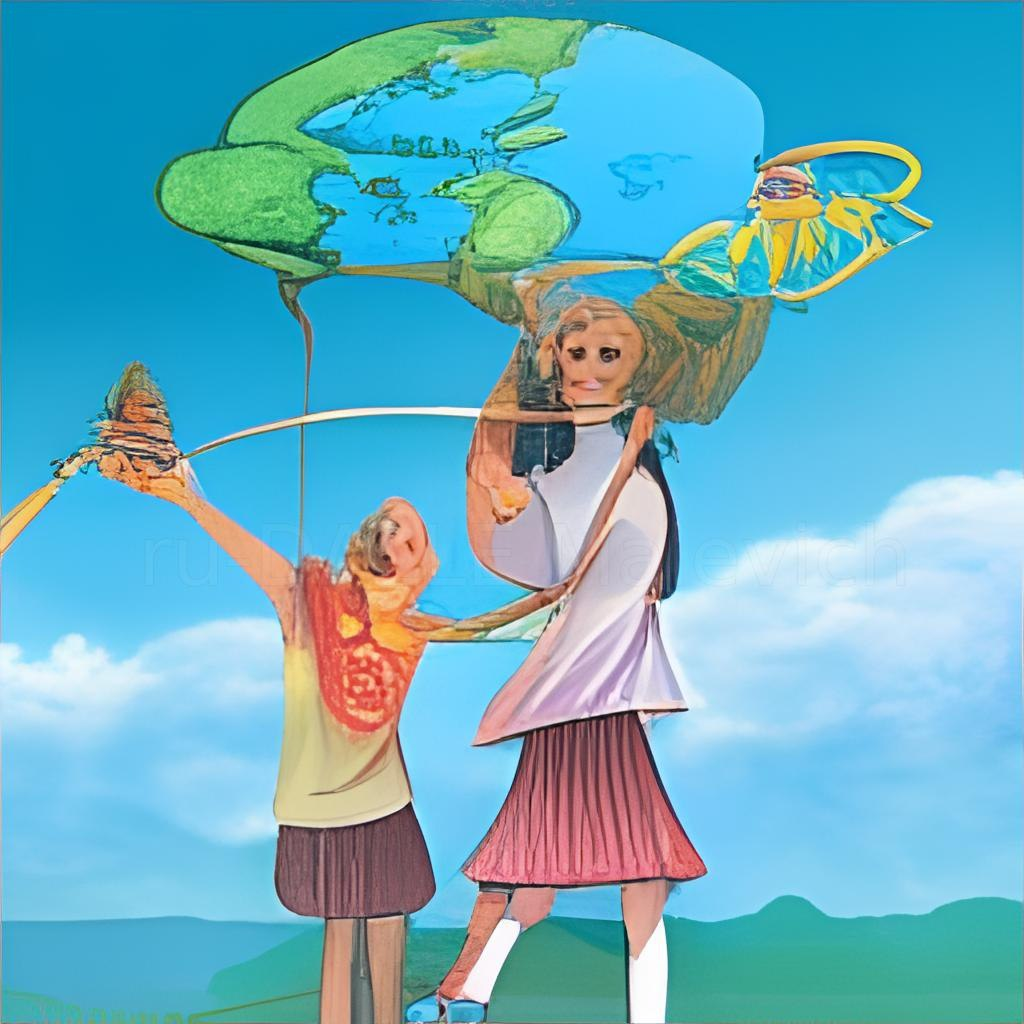

Изображение сгенерировано моделью ruDALL-E от Сбера по запросу "девочка аня в тотальном ужасе от качества работы ruDALLE"

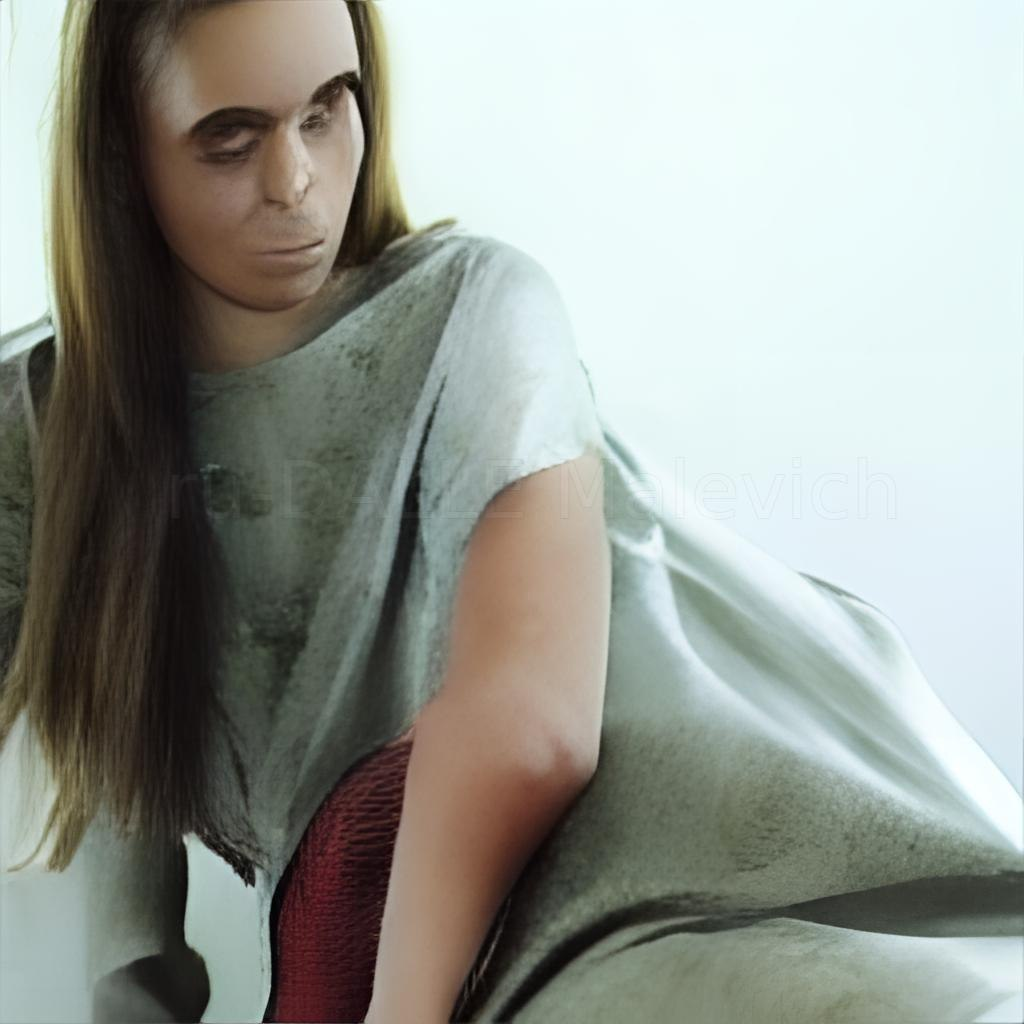

Изображение сгенерировано моделью ruDALL-E от Сбера по запросу "Преподаватель проверяет домашнее задание и ставит высший балл"

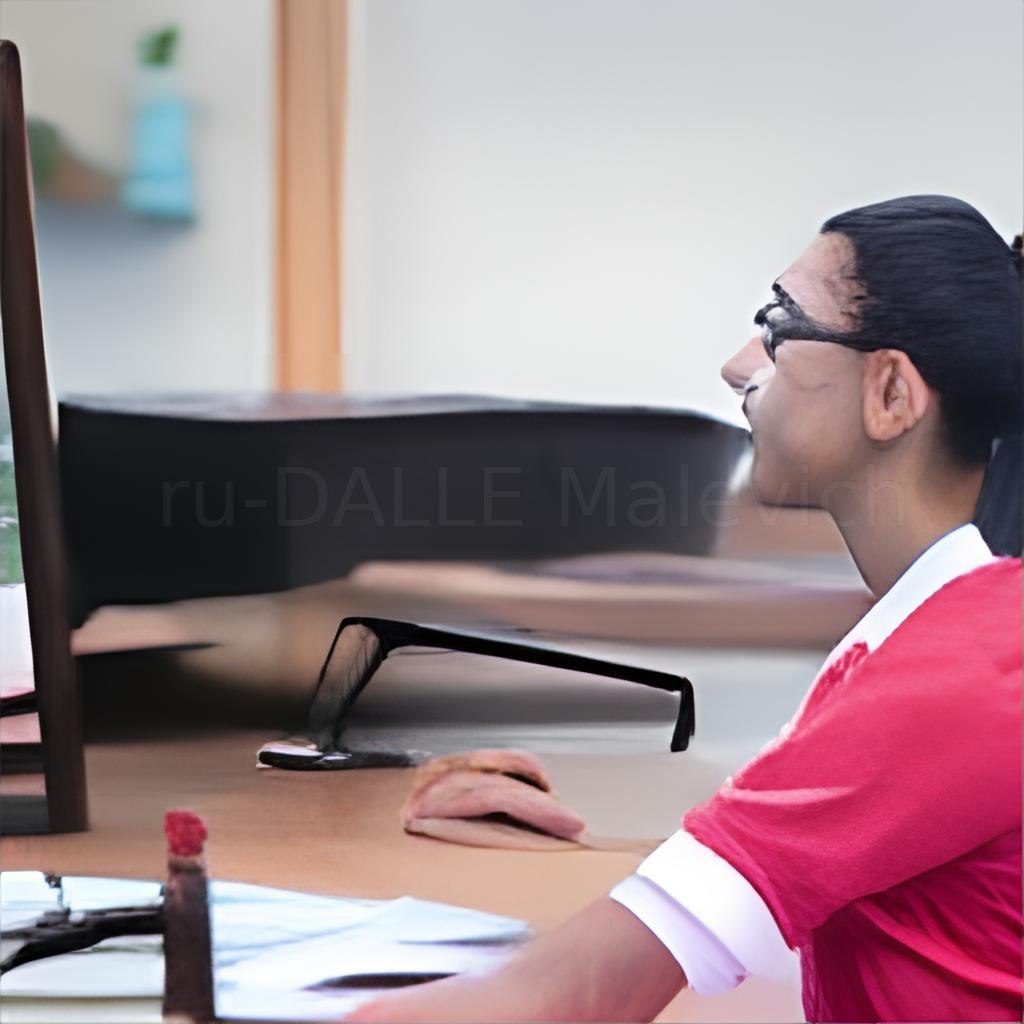